# Project 01 - El Niño and La Niña

 * In the project, we study the daily mean SST in the equatorial Pacific. The corresponding time series is given below. The high SST values correspond to Nino events and the low SST to Nina events. Study the spatial distribution of SST and SSH in these 2 extreme situations.

## Environment Setup

In [1]:
!pip install basemap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 935.8/935.8 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 28.0 MB/s eta 0:00:00


In [2]:
# Plot libraries
%matplotlib inline
%pylab inline
from mpl_toolkits.basemap import Basemap
import sklearn
import pandas as pd
from scipy.stats.mstats import zscore
import warnings
warnings.filterwarnings("ignore") # disable warnings
pylab.rcParams['figure.figsize']=(10,10) # graph size

# Xarray libraries
import xarray as xr
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [3]:
# function to plot images
def plot_im(lon,lat,im,size_points,var_name):

    # transform to arrays (just in case)
    lon=array(lon)
    lat=array(lat)
    im=array(im)

    if max(lon)-min(lon)<130:
      # Mercator projection (for small zone)
      m=Basemap(projection='merc',llcrnrlat=nanmin(lat),urcrnrlat=nanmax(lat),\
                llcrnrlon=nanmin(lon),urcrnrlon=nanmax(lon),lat_0=(nanmax(lat)+nanmin(lat))*0.5,\
                lon_0=(nanmax(lon)+nanmin(lon))*0.5,resolution='l')
    else:
      # Orthogonal projection (for large zone)
      m=Basemap(projection='robin',lat_0=0,lon_0=0,resolution='l')
    # you can use other projections (see https://matplotlib.org/basemap/users/mapsetup.html)

    # transform (lon,lat) to (x,y)
    x,y=m(lon,lat)

    # plot
    #im=ma.masked_where(isnan(im),im)
    res=m.scatter(x,y,size_points,im,'o',alpha=1,cmap='jet',lw=0)
    m.drawcoastlines()
    m.fillcontinents()
    parallels = linspace(nanmin(lat),nanmax(lat),15)
    meridians = linspace(nanmin(lon),nanmax(lon),15)
    #m.drawparallels(parallels,labels=[1,0,0,1],fontsize=10)
    #m.drawmeridians(meridians,labels=[1,0,0,1],fontsize=10)
    cb=m.colorbar(res,location="right")
    cb.set_label(var_name,fontsize=15)

# function to plot time series
def plot_ts(time,ts,line_type,var_name):

    # plot
    plot_date(time- 719177.25,ts,line_type)
    xlabel('Time',fontsize=15)
    ylabel(var_name,fontsize=15)

In [4]:
# Google Cloud Connection
import os
os.environ['USE_AUTH_EPHEM'] = '0'

from google.colab import auth
auth.authenticate_user()

## Data Analysis

* In this part, we visualize the SST data in range of latitude [-20:20] and longitude of [180:300] in the time series and the world map.

### Time Series Analysis


In [5]:
#Create the time series of the mean SST over the selected zone (bigger than the index Niño 3.4)
%%bigquery ref_output --project alert-ground-261008
SELECT time, AVG(sst) AS sst_mean
FROM bdo2020.bdo2020.1998_2015
WHERE lon>180 AND lon<300 AND lat>-20 AND lat<20
GROUP BY time
ORDER BY time

Query is running:   0%|          |

Downloading:   0%|          |

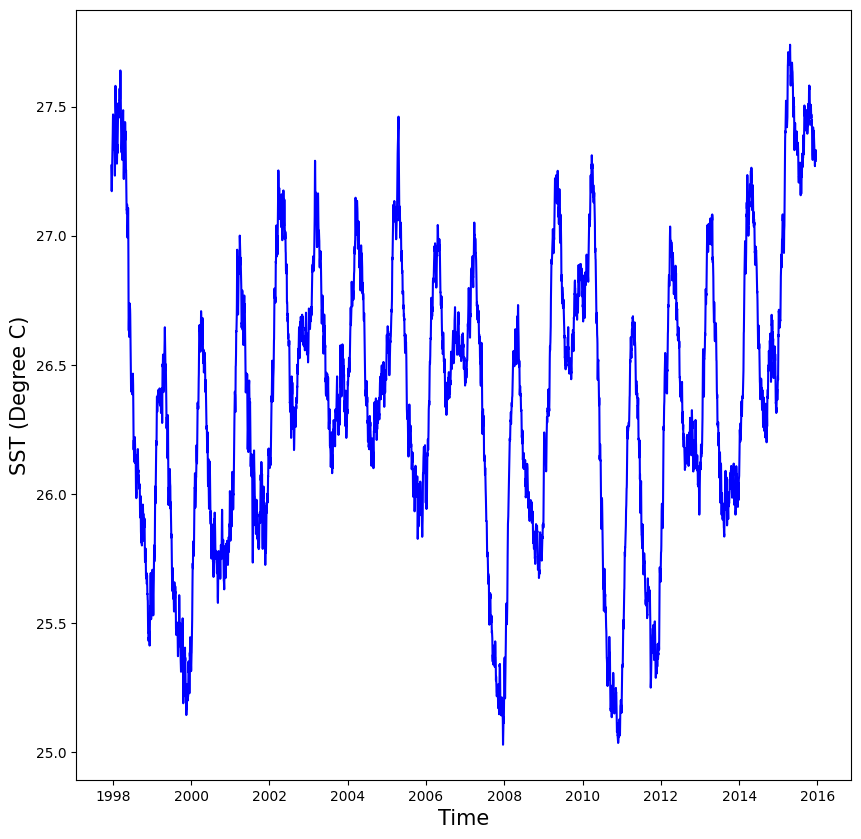

In [6]:
plot_ts(ref_output.time, ref_output.sst_mean, '-b', 'SST (Degree C)')

### Heatmap


In [7]:
# Create the map of the temporal mean SST in the same zone
%%bigquery output --project alert-ground-261008
SELECT lon, lat, AVG(sst) AS mean_sst
FROM bdo2020.bdo2020.1998_2015_withtimes
WHERE lon>180 AND lon<300 AND lat>-20 AND lat<20
GROUP BY lon, lat

Query is running:   0%|          |

Downloading:   0%|          |

Text(0.5, 1.0, 'Mean over the years 1998-2015')

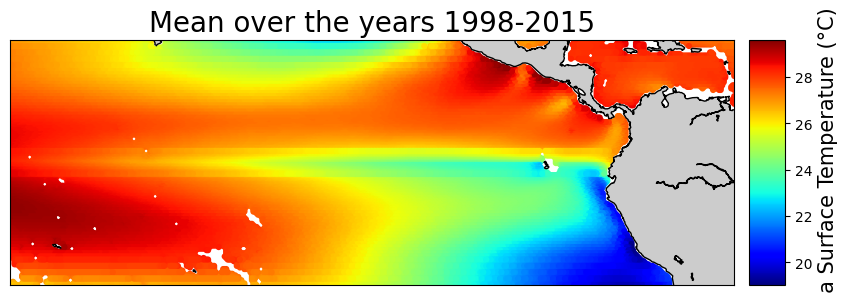

In [8]:
plot_im(output.lon, output.lat, output.mean_sst, 20, 'Sea Surface Temperature (°C)')
title('Mean over the years 1998-2015', size=20)

## PCA Decomposition

### PCA withXarray

In [9]:
# Data Loading
%%bigquery output --project alert-ground-261008
SELECT month, year, lon, lat, AVG(sst) AS mean_sst
FROM bdo2020.bdo2020.1998_2015_withtimes
WHERE lon>119 AND lon<284 AND lat>-40 AND lat<40
GROUP BY month, year, lon, lat
ORDER BY month, year

Query is running:   0%|          |

Downloading:   0%|          |

In [10]:
output['date'] = pd.to_datetime(output[['year', 'month']].assign(DAY=1))

In [11]:
output = output[['date', 'lat', 'lon', 'mean_sst']].set_index(['date', 'lat', 'lon']).to_xarray().mean_sst

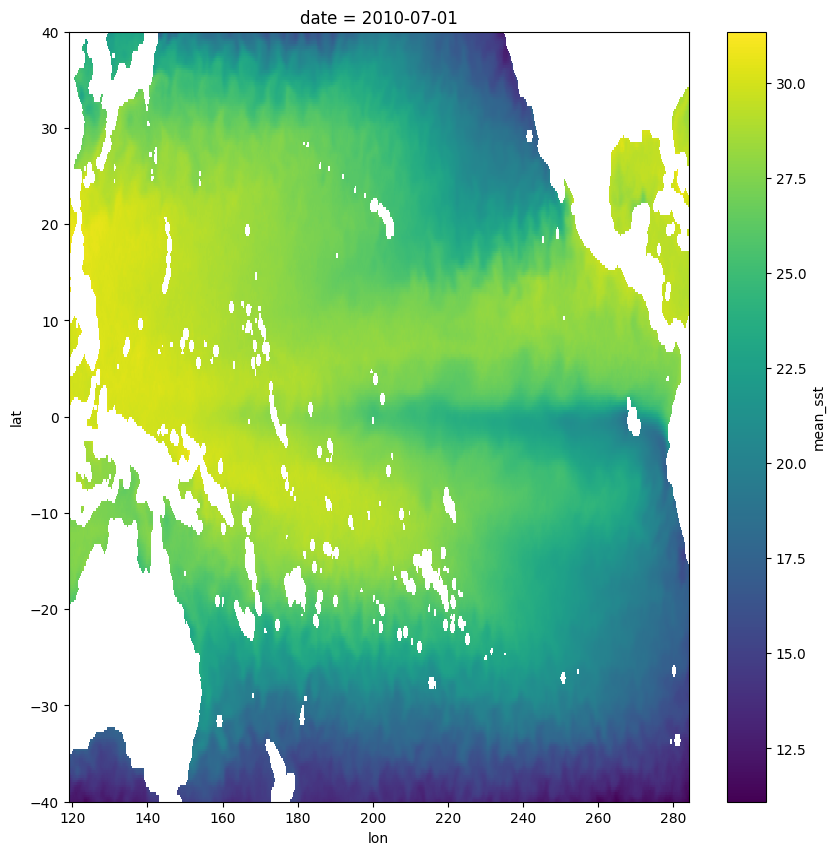

In [12]:
# Plot the temperature map in random month
output.isel(date=150).plot()

In [13]:
data = output.values

In [14]:
#Creation of a numpy array for the following, useful for PCA
data = np.array([data[i].ravel() for i in range(len(data))])

In [15]:
data.shape

(217, 211200)

In [16]:
from sklearn.decomposition import PCA

In [17]:
pca = PCA(n_components=10)

In [18]:
#Suppression of the Nan data
data_nonan = np.array([data[i][~np.isnan(data[0])] for i in range(len(data))])

In [19]:
pca.fit(data_nonan)

PCA(n_components=10)

In [20]:
Xpca = pca.transform(data_nonan)

In [21]:
pcacomp = pca.components_

In [22]:
pcacomp.shape

(10, 169475)

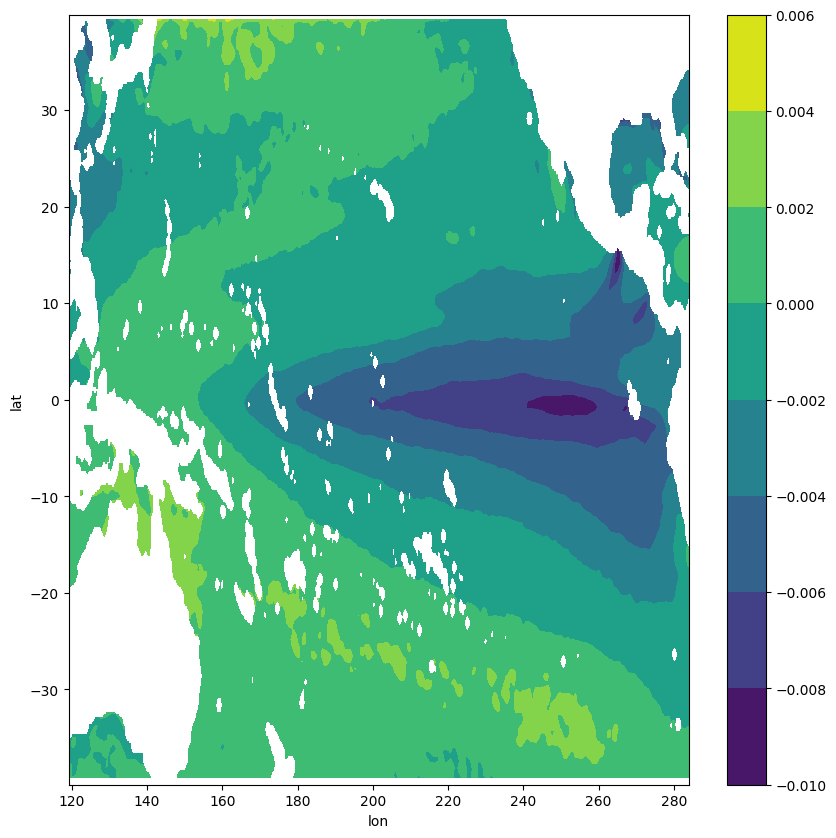

In [23]:
component_used1 = 1

pattern1 = data[0].copy()
pattern1[~np.isnan(data[0])] = pcacomp[component_used1]
pattern1 = pattern1.reshape(output.values[0].shape)

plt.contourf(output.lon, output.lat, pattern1)
plt.xlabel('lon')
plt.ylabel('lat')
plt.colorbar()

Text(0.5, 0, 'time (months)')

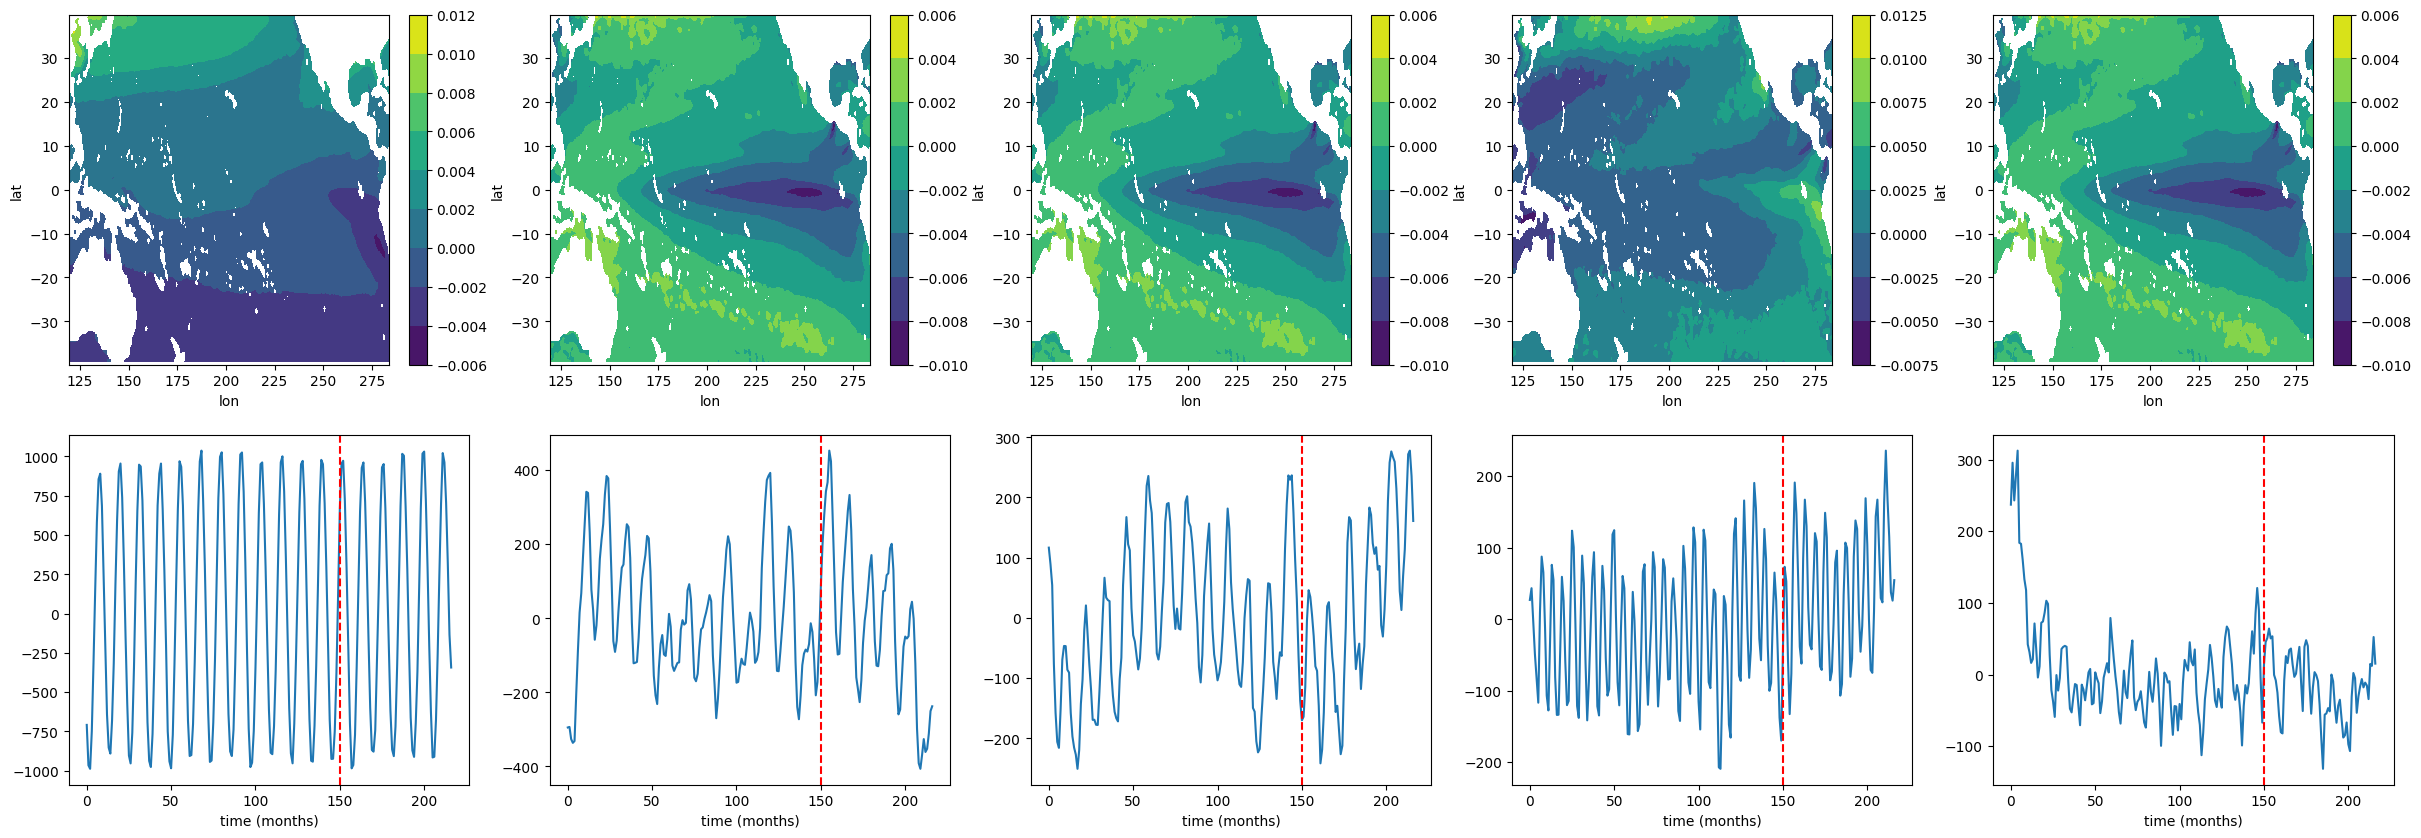

In [24]:
#Plot of the time series and map pattern of each PCA component to observe their weight on the real map
plt.figure(figsize=(30,10))
component_used1 = 0

pattern1 = data[0].copy()
pattern1[~np.isnan(data[0])] = pcacomp[component_used1]
pattern1 = pattern1.reshape(output.values[0].shape)

plt.subplot(2,5,1)
plt.contourf(output.lon, output.lat, pattern1)
plt.xlabel('lon')
plt.ylabel('lat')
plt.colorbar()

component_used2 = 1

pattern2 = data[0].copy()
pattern2[~np.isnan(data[0])] = pcacomp[component_used2]
pattern2 = pattern2.reshape(output.values[0].shape)

plt.subplot(2,5,2)
plt.contourf(output.lon, output.lat, pattern2)
plt.xlabel('lon')
plt.ylabel('lat')
plt.colorbar()

component_used3 = 2

pattern3 = data[0].copy()
pattern3[~np.isnan(data[0])] = pcacomp[component_used3]
pattern3 = pattern2.reshape(output.values[0].shape)

plt.subplot(2,5,3)
plt.contourf(output.lon, output.lat, pattern3)
plt.xlabel('lon')
plt.ylabel('lat')
plt.colorbar()

component_used4 = 3

pattern4 = data[0].copy()
pattern4[~np.isnan(data[0])] = pcacomp[component_used4]
pattern4 = pattern4.reshape(output.values[0].shape)

plt.subplot(2,5,4)
plt.contourf(output.lon, output.lat, pattern4)
plt.xlabel('lon')
plt.ylabel('lat')
plt.colorbar()

component_used5 = 1

pattern5 = data[0].copy()
pattern5[~np.isnan(data[0])] = pcacomp[component_used5]
pattern5 = pattern2.reshape(output.values[0].shape)

plt.subplot(2,5,5)
plt.contourf(output.lon, output.lat, pattern5)
plt.xlabel('lon')
plt.ylabel('lat')
plt.colorbar()


plt.subplot(2,5,6)
plt.plot(Xpca[:,0])
plt.axvline(x=150, color='red', linestyle='--')
plt.xlabel('time (months)')

plt.subplot(2,5,7)
plt.plot(Xpca[:,1])
plt.axvline(x=150, color='red', linestyle='--')
plt.xlabel('time (months)')

plt.subplot(2,5,8)
plt.plot(Xpca[:,2])
plt.axvline(x=150, color='red', linestyle='--')
plt.xlabel('time (months)')

plt.subplot(2,5,9)
plt.plot(Xpca[:,3])
plt.axvline(x=150, color='red', linestyle='--')
plt.xlabel('time (months)')

plt.subplot(2,5,10)
plt.plot(Xpca[:,4])
plt.axvline(x=150, color='red', linestyle='--')
plt.xlabel('time (months)')

### PCA by manual DataFrame Processing

#### Data Preparation

In [25]:
# Take data
%%bigquery output --project alert-ground-261008
SELECT  month, year, lon, lat, AVG(sst) AS mean_sst
FROM bdo2020.bdo2020.1998_2015_withtimes
WHERE lon>180 AND lon<300 AND lat>-20 AND lat<20
GROUP BY month, year, lon, lat
ORDER BY year, month

Query is running:   0%|          |

Downloading:   0%|          |

In [26]:
# Convert "month" and "year" columns to strings and concatenate
output['time'] = output['year'].astype(str) + '-' + output['month'].astype(str)

# If you want to convert the 'time' column to a datetime object, you can do the following:
output['time'] = pd.to_datetime(output['time'], format='%Y-%m')

output1 = output.drop(['month', 'year'], axis=1)
output1

,lon,lat,mean_sst,time
0,183.375,15.625,26.330,1998-01-01
1,280.875,3.625,27.450,1998-01-01
2,299.875,18.375,26.815,1998-01-01
3,185.875,-14.125,28.500,1998-01-01
4,186.375,5.875,28.010,1998-01-01
...,...,...,...,...
13700724,239.875,-3.375,27.450,2016-01-01
13700725,276.125,-13.125,22.200,2016-01-01
13700726,184.625,-4.625,29.850,2016-01-01
13700727,268.625,-7.875,24.900,2016-01-01


In [27]:
pivoted_df = output1.pivot(index='time', columns=['lon', 'lat'], values='mean_sst')
pivoted_df

lon,183.375,280.875,299.875,185.875,186.375,246.625,209.375,240.125,197.375,213.125,...,239.375,183.375,233.875,275.875,204.625,181.125,199.625,198.875,229.375,206.625
lat,15.625,3.625,18.375,-14.125,5.875,-4.875,-10.875,-1.625,18.375,18.375,...,-16.375,-11.625,1.125,3.625,11.375,11.375,-18.625,5.125,-19.375,-15.625
time,,,,,,,,,,,,,,,,,,,,,
1998-01-01,26.330000,27.450000,26.815000,28.500000,28.010000,28.005000,29.895000,28.375000,25.110000,24.700000,...,26.425000,28.780000,28.575000,29.165000,25.955000,26.735000,27.710000,28.220000,27.220000,29.015000
1998-02-01,25.623214,28.210714,26.603571,28.355357,28.130357,28.371429,29.560714,28.628571,24.958929,24.225000,...,27.026786,28.805357,28.141071,28.794643,25.392857,26.083929,26.914286,28.082143,28.237500,29.250000
1998-03-01,25.824194,28.548387,26.487097,28.964516,28.074194,28.635484,29.854839,28.950000,25.035484,24.188710,...,27.401613,29.124194,28.403226,29.404839,25.345161,26.196774,27.793548,28.180645,28.795161,29.332258
1998-04-01,25.485000,29.070000,26.690000,28.560000,27.845000,28.575000,29.620000,28.785000,24.755000,23.495000,...,27.300000,28.660000,27.865000,29.495000,24.830000,26.170000,27.175000,27.695000,27.800000,28.630000
1998-05-01,25.795161,28.983871,27.590323,27.924194,27.924194,28.287097,29.419355,27.387097,24.735484,23.366129,...,26.995161,28.674194,26.830645,29.211290,25.456452,26.777419,25.867742,27.812903,26.811290,28.514516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-09-01,30.020000,28.105000,29.380000,27.280000,29.650000,25.995000,28.435000,26.985000,29.425000,27.220000,...,24.590000,28.370000,27.745000,28.040000,29.470000,29.965000,24.790000,29.945000,24.590000,27.420000
2015-10-01,28.833871,28.291935,29.516129,27.488710,29.104839,26.308065,29.124194,27.000000,28.146774,26.888710,...,24.977419,28.785484,28.200000,27.885484,28.451613,28.964516,25.267742,29.656452,25.035484,27.846774


#### Number of components selection

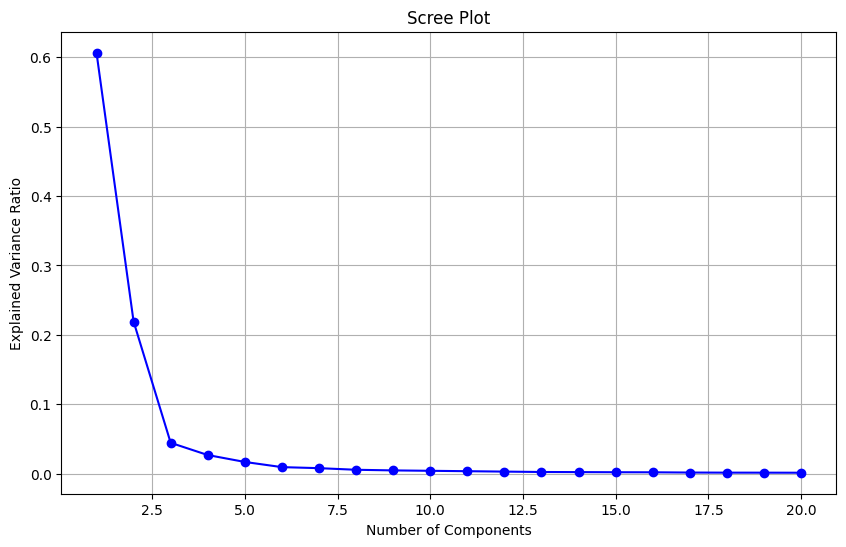

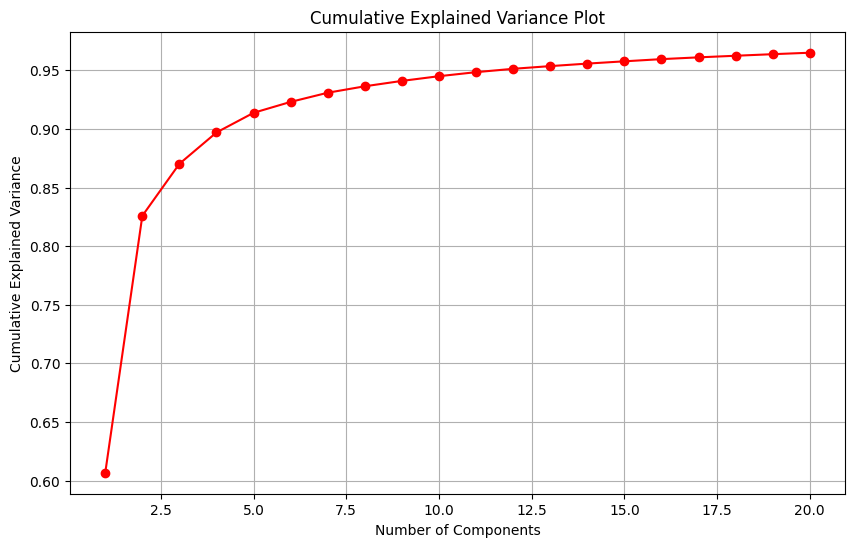

In [28]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(pivoted_df)
# Plotting the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_[:20]
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), explained_variance_ratio, marker='o', linestyle='-', color='b')
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), cumulative_explained_variance, marker='o', linestyle='-', color='r')
plt.title('Cumulative Explained Variance Plot')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

* We chose 3 components for PCA

#### Reconstruct SST from the time series and map of patterns

In [29]:
# PCA model with 3 components
pca = PCA(n_components = 3)
pca.fit(pivoted_df)
time_components = pca.transform(pivoted_df)

In [30]:
# Time Series of components (patterns)
time_components.shape

(217, 3)

In [31]:
# Reconstruct the Time Series of SST data from Time Series and Map of Patterns
output_reconstructed = np.dot(time_components,pca.components_)
output_reconstructed = output_reconstructed.mean(axis = 1)
output_reconstructed.shape

(217,)

In [32]:
# the Time Series of SST data from original data
pivoted_df['mean'] = pivoted_df.mean(axis = 1)

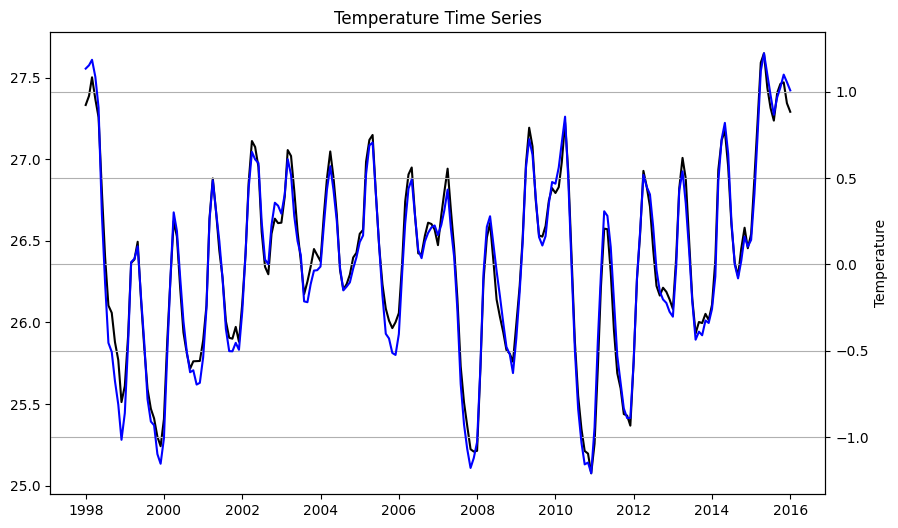

In [33]:
# Compare the reconstructed data (blue) and original data (black)
plt.figure(figsize=(10, 6))
plt.plot(pivoted_df.index, pivoted_df['mean'], linestyle='-', color='k')
twinx()
plt.plot(pivoted_df.index,output_reconstructed,  linestyle='-', color='b')
plt.title('Temperature Time Series')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.grid(True)
plt.show()

* The reconstructed data seems to well describe the original data but in the different scales.
* Because data will be normalized in PCA, so it is difficult to compare them. So we will use another method to reconstruct SST data from the time series of patterns.

#### Time series of pattern: Multiple Linear regression

In [34]:
# import the LinearRegression method from scikit-learn
from sklearn.linear_model import LinearRegression

# Data preparation
X = time_components
y = pivoted_df['mean']

# 2: create the model, as before
model = LinearRegression()

# 3: fit the model, as before
model.fit(X,y)

print('Model coefficients for [a1, a2, a3]: {}'.format(model.coef_))
print('Model coefficient for b: {}'.format(model.intercept_))

Model coefficients for [a1, a2, a3]: [0.00140986 0.00288102 0.0006099 ]
Model coefficient for b: 26.37881649457056


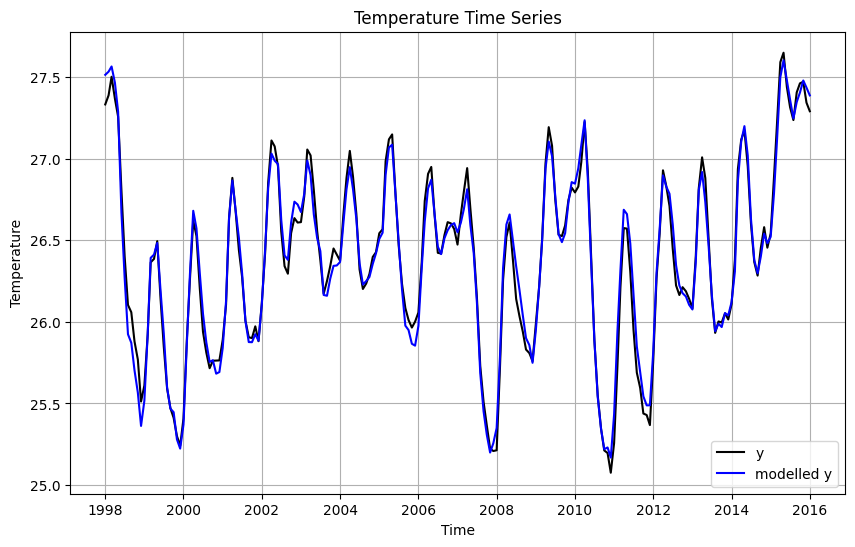

In [35]:
# 4: get predicted values for y, as before
y_hat = model.predict(X)

# 5: plot the real and modelled values
plt.figure(figsize=(10, 6))
plt.plot(pivoted_df.index,y,label='y', linestyle='-', color='k')
plt.plot(pivoted_df.index,y_hat,label='modelled y',  linestyle='-', color='b')
plt.title('Temperature Time Series')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.grid()

#### Maps of pattern

In [36]:
# Patterns shape
pca.components_.shape

(3, 63137)

In [37]:
# Take input
map_pattern_values = pca.components_
pixel_coords = pivoted_df.columns.drop('mean')

In [38]:
# Coordinate shape
pixel_coords.shape

(63137,)

In [39]:
# Data frame from values and colums
map_pattern = pd.DataFrame(map_pattern_values.T, pixel_coords).reset_index()

In [40]:
# Rename columns
map_pattern.columns = ['lon', 'lat', 'component1', 'component2', 'component3']
map_pattern

,lon,lat,component1,component2,component3
0,183.375,15.625,-0.002859,0.002239,0.000643
1,280.875,3.625,-0.000135,0.003434,-0.001816
2,299.875,18.375,-0.003672,0.002788,-0.002831
3,185.875,-14.125,0.001742,-0.001346,0.002724
4,186.375,5.875,-0.001711,0.003063,0.004821
...,...,...,...,...,...
63132,181.125,11.375,-0.001899,0.002004,0.000806
63133,199.625,-18.625,0.003024,-0.002780,0.002694
63134,198.875,5.125,-0.001602,0.005030,0.005162
63135,229.375,-19.375,0.003965,-0.001692,0.004214


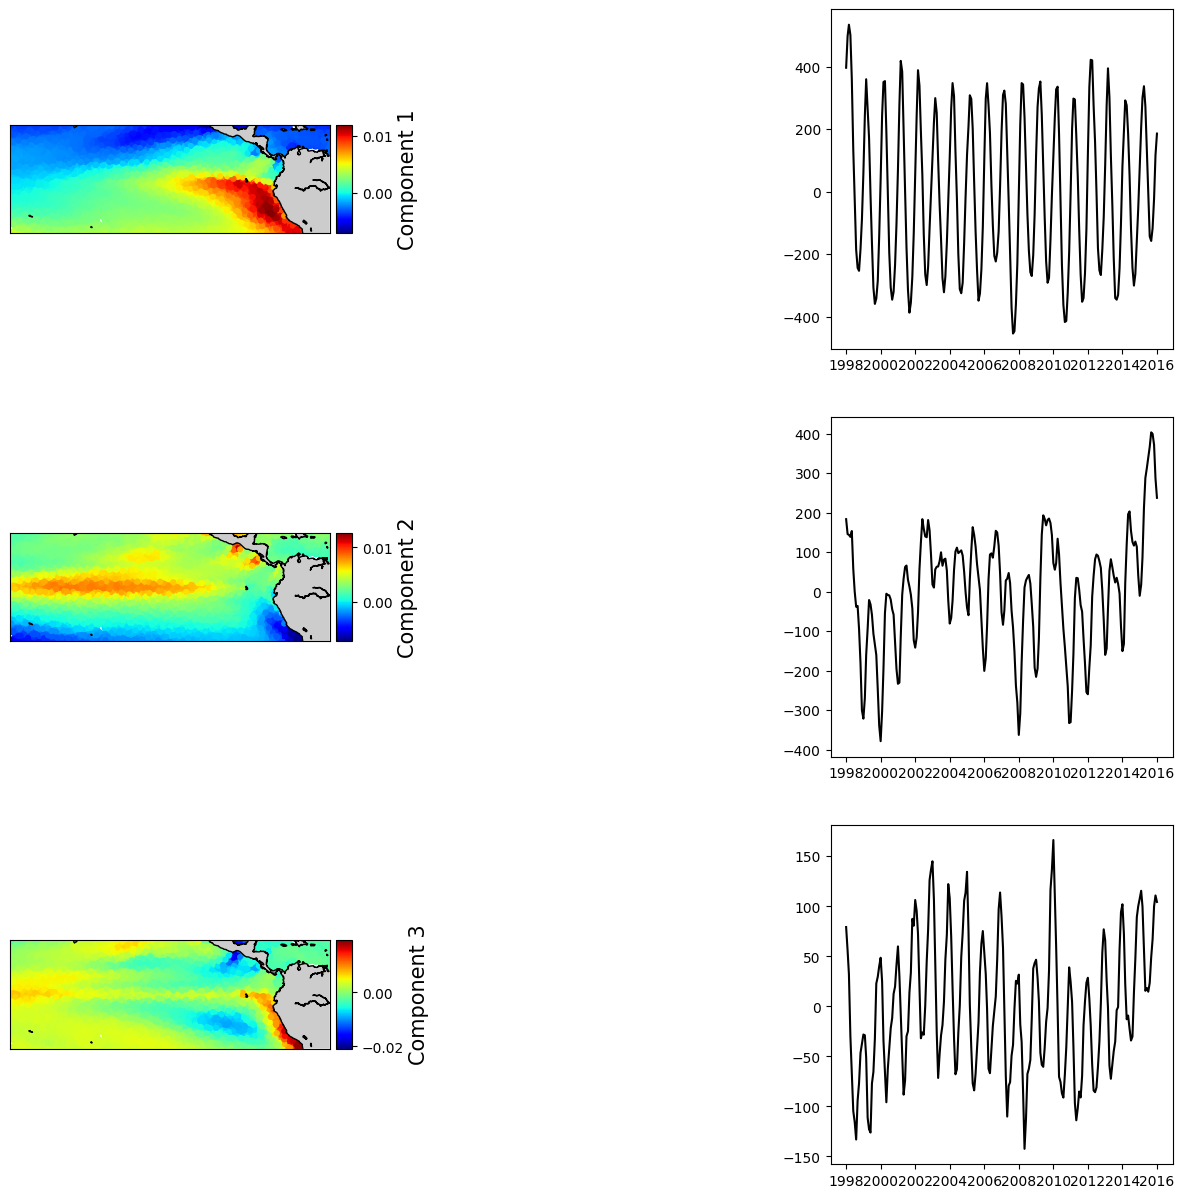

In [41]:
figure(figsize=(15,15))
# Map Plot
subplot(3,3,1)
plot_im(map_pattern['lon'], map_pattern['lat'], map_pattern['component1'], 20, 'Component 1')
subplot(3,3,4)
plot_im(map_pattern['lon'], map_pattern['lat'], map_pattern['component2'], 20, 'Component 2')
subplot(3,3,7)
plot_im(map_pattern['lon'], map_pattern['lat'], map_pattern['component3'], 20, 'Component 3')

# Time Series Plot
subplot(3,3,3)
plt.plot(pivoted_df.index, X[:,0], linestyle='-', color='k')
subplot(3,3,6)
plt.plot(pivoted_df.index, X[:,1], linestyle='-', color='k')
subplot(3,3,9)
plt.plot(pivoted_df.index, X[:,2], linestyle='-', color='k')

In [42]:
# The contribution of each component
pca.explained_variance_ratio_

array([0.60664896, 0.21922352, 0.04437331])

## Draw the error


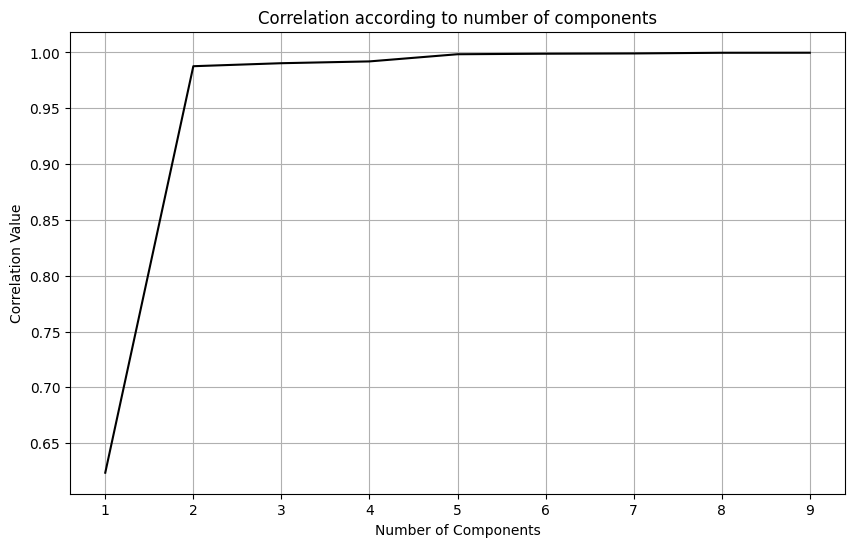

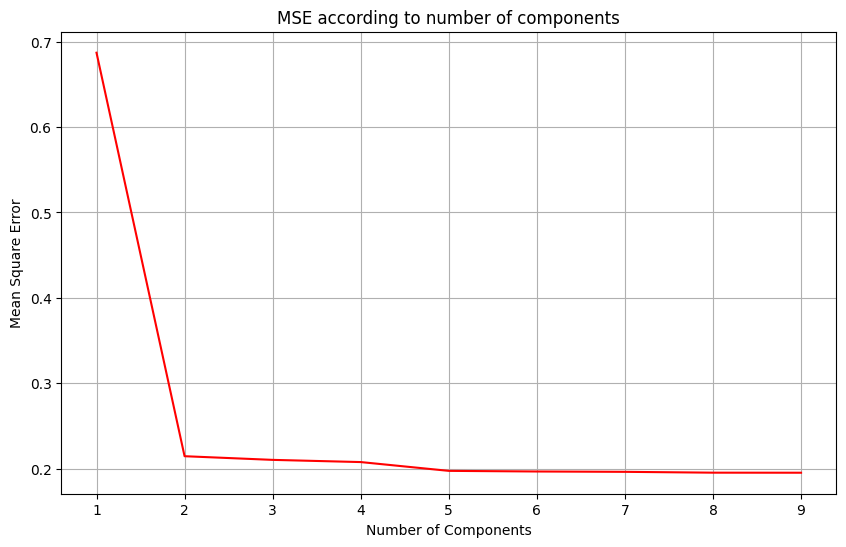

In [43]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

pivoted_df = output1.pivot(index='time', columns=['lon', 'lat'], values='mean_sst')
pivoted_df['mean'] = pivoted_df.mean(axis = 1)
# Drop all other columns
ref_df = pivoted_df['mean']
ref_df = ref_df.to_frame()
scaler = StandardScaler()
ref_df = pd.DataFrame(scaler.fit_transform(ref_df), columns=['mean'])
ref_df = ref_df.reset_index(drop=True)

correlation = []
MSE = []

for i in range(1,10):
  pca = PCA(n_components = i)
  pca.fit(pivoted_df)
  time_components = pca.transform(pivoted_df)
  output_reconstructed = np.dot(time_components,pca.components_)
  output_reconstructed = output_reconstructed.mean(axis = 1)
  pred = pd.DataFrame(output_reconstructed, columns=['mean'])
  correlation_value = ref_df.corrwith(pred)
  MSE_value = mean_squared_error(pred, ref_df)
  correlation.append(correlation_value)
  MSE.append(MSE_value)

plt.figure(figsize=(10, 6))
plt.plot(range(1,len(correlation)+1), correlation, linestyle='-', color='k')
plt.title('Correlation according to number of components')
plt.xlabel('Number of Components')
plt.ylabel('Correlation Value')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1,len(correlation)+1), MSE, linestyle='-', color='r')
plt.title('MSE according to number of components')
plt.xlabel('Number of Components')
plt.ylabel('Mean Square Error')
plt.grid(True)
plt.show()

## Prediction

In [44]:
pivoted_df = output1.pivot(index='time', columns=['lon', 'lat'], values='mean_sst')
pivoted_df.head(204)

lon,183.375,280.875,299.875,185.875,186.375,246.625,209.375,240.125,197.375,213.125,...,239.375,183.375,233.875,275.875,204.625,181.125,199.625,198.875,229.375,206.625
lat,15.625,3.625,18.375,-14.125,5.875,-4.875,-10.875,-1.625,18.375,18.375,...,-16.375,-11.625,1.125,3.625,11.375,11.375,-18.625,5.125,-19.375,-15.625
time,,,,,,,,,,,,,,,,,,,,,
1998-01-01,26.330000,27.450000,26.815000,28.500000,28.010000,28.005000,29.895000,28.375000,25.110000,24.700000,...,26.425000,28.780000,28.575000,29.165000,25.955000,26.735000,27.710000,28.220000,27.220000,29.015000
1998-02-01,25.623214,28.210714,26.603571,28.355357,28.130357,28.371429,29.560714,28.628571,24.958929,24.225000,...,27.026786,28.805357,28.141071,28.794643,25.392857,26.083929,26.914286,28.082143,28.237500,29.250000
1998-03-01,25.824194,28.548387,26.487097,28.964516,28.074194,28.635484,29.854839,28.950000,25.035484,24.188710,...,27.401613,29.124194,28.403226,29.404839,25.345161,26.196774,27.793548,28.180645,28.795161,29.332258
1998-04-01,25.485000,29.070000,26.690000,28.560000,27.845000,28.575000,29.620000,28.785000,24.755000,23.495000,...,27.300000,28.660000,27.865000,29.495000,24.830000,26.170000,27.175000,27.695000,27.800000,28.630000
1998-05-01,25.795161,28.983871,27.590323,27.924194,27.924194,28.287097,29.419355,27.387097,24.735484,23.366129,...,26.995161,28.674194,26.830645,29.211290,25.456452,26.777419,25.867742,27.812903,26.811290,28.514516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-08-01,28.427419,27.551613,28.470968,28.214516,29.714516,24.803226,27.609677,24.314516,27.745161,25.761290,...,24.290323,28.630645,25.204839,27.687097,28.175806,28.717742,25.916129,29.012903,24.590323,27.454839
2014-09-01,28.475000,27.505000,28.735000,28.130000,29.795000,23.650000,27.835000,24.205000,28.020000,26.640000,...,24.085000,28.550000,25.545000,26.950000,28.120000,28.910000,25.545000,29.325000,24.690000,27.535000


In [45]:
#pivoted_df = output1.pivot(index='time', columns=['lon', 'lat'], values='mean_sst')
train_df = pivoted_df.head(204)
pca = PCA(n_components = 1)
pca.fit(train_df)
time_components = pca.transform(train_df)

In [46]:
time_components = pd.DataFrame(time_components, columns = ['component1'])
time_components

,component1
0,398.230344
1,500.059761
2,536.901605
3,504.781718
4,364.466755
...,...
199,-240.229601
200,-297.387891
201,-260.695501
202,-152.431493


In [47]:
num_columns = 12  # Specify the number of columns
X = pd.concat([time_components.shift(-i) for i in range(num_columns)], axis=1).dropna().astype(float)
print(X.shape)
X

(193, 12)


,component1,component1,component1,component1,component1,component1,component1,component1,component1,component1,component1,component1
0,398.230344,500.059761,536.901605,504.781718,364.466755,139.187470,-21.550418,-179.100655,-237.649597,-246.173608,-175.878199,-79.599980
1,500.059761,536.901605,504.781718,364.466755,139.187470,-21.550418,-179.100655,-237.649597,-246.173608,-175.878199,-79.599980,69.538432
2,536.901605,504.781718,364.466755,139.187470,-21.550418,-179.100655,-237.649597,-246.173608,-175.878199,-79.599980,69.538432,252.921585
3,504.781718,364.466755,139.187470,-21.550418,-179.100655,-237.649597,-246.173608,-175.878199,-79.599980,69.538432,252.921585,367.790209
4,364.466755,139.187470,-21.550418,-179.100655,-237.649597,-246.173608,-175.878199,-79.599980,69.538432,252.921585,367.790209,272.540386
...,...,...,...,...,...,...,...,...,...,...,...,...
188,-340.889229,-325.827788,-240.024105,-95.532507,88.104107,196.150519,295.994944,279.399366,187.778543,51.890722,-116.350188,-240.229601
189,-325.827788,-240.024105,-95.532507,88.104107,196.150519,295.994944,279.399366,187.778543,51.890722,-116.350188,-240.229601,-297.387891
190,-240.024105,-95.532507,88.104107,196.150519,295.994944,279.399366,187.778543,51.890722,-116.350188,-240.229601,-297.387891,-260.695501
191,-95.532507,88.104107,196.150519,295.994944,279.399366,187.778543,51.890722,-116.350188,-240.229601,-297.387891,-260.695501,-152.431493


In [48]:
Y = pd.DataFrame(pivoted_df.mean(axis = 1).iloc[13:206]).reset_index(drop = True)
Y.shape

(193, 1)

In [49]:
from sklearn.linear_model import LinearRegression
# 2: create the model, as before
model = LinearRegression()

# 3: fit the model, as before
model.fit(X[:-50],Y[:-50])
print('Model coefficients: {}'.format(model.coef_))
print('Model coefficient for b: {}'.format(model.intercept_))

Model coefficients: [[-2.37975638e-03  1.82938080e-03  1.20637693e-04 -1.71004939e-04
  -9.30875139e-05  5.79270143e-04  1.12426168e-03 -5.96922653e-05
   9.18169353e-05  8.43931076e-04 -3.21701741e-03  6.04110729e-03]]
Model coefficient for b: [26.35883807]


In [50]:
X[:-50]

,component1,component1,component1,component1,component1,component1,component1,component1,component1,component1,component1,component1
0,398.230344,500.059761,536.901605,504.781718,364.466755,139.187470,-21.550418,-179.100655,-237.649597,-246.173608,-175.878199,-79.599980
1,500.059761,536.901605,504.781718,364.466755,139.187470,-21.550418,-179.100655,-237.649597,-246.173608,-175.878199,-79.599980,69.538432
2,536.901605,504.781718,364.466755,139.187470,-21.550418,-179.100655,-237.649597,-246.173608,-175.878199,-79.599980,69.538432,252.921585
3,504.781718,364.466755,139.187470,-21.550418,-179.100655,-237.649597,-246.173608,-175.878199,-79.599980,69.538432,252.921585,367.790209
4,364.466755,139.187470,-21.550418,-179.100655,-237.649597,-246.173608,-175.878199,-79.599980,69.538432,252.921585,367.790209,272.540386
...,...,...,...,...,...,...,...,...,...,...,...,...
138,-77.914495,-220.615039,-289.321838,-274.249011,-151.226511,-10.130696,115.224670,241.264713,330.885919,338.649912,189.842934,-17.234533
139,-220.615039,-289.321838,-274.249011,-151.226511,-10.130696,115.224670,241.264713,330.885919,338.649912,189.842934,-17.234533,-227.936631
140,-289.321838,-274.249011,-151.226511,-10.130696,115.224670,241.264713,330.885919,338.649912,189.842934,-17.234533,-227.936631,-354.698578
141,-274.249011,-151.226511,-10.130696,115.224670,241.264713,330.885919,338.649912,189.842934,-17.234533,-227.936631,-354.698578,-409.226300


In [51]:
y_pred=model.predict(X.tail(50))
Y.tail(50)
rms = np.sqrt(np.mean((y_pred - Y.tail(50))**2))
print(rms)

0    0.341049
dtype: float64


In [52]:
mae = np.mean(np.abs(y_pred -  Y.tail(50)))
print(mae)

0    0.278646
dtype: float64


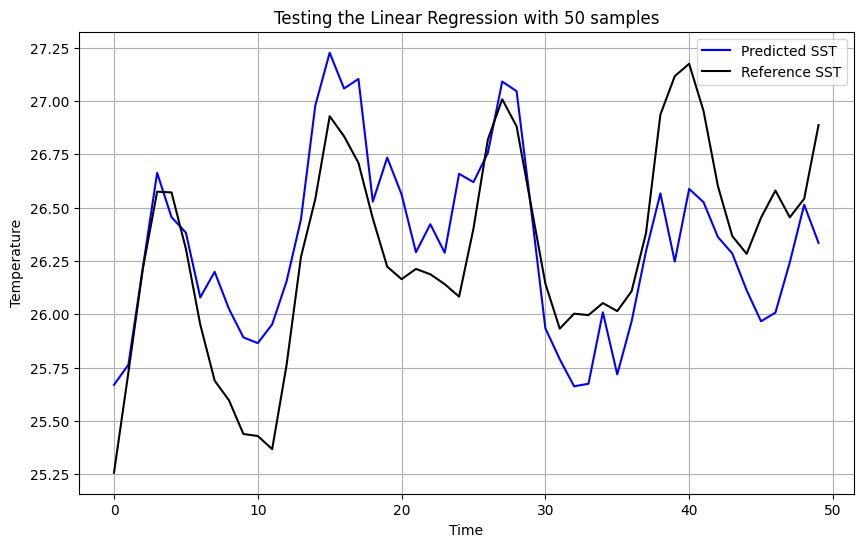

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(range(50), y_pred, linestyle='-', color='b')
plt.plot(range(50), Y.tail(50),  linestyle='-', color='k')
plt.title('Testing the Linear Regression with 50 samples')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend(['Predicted SST','Reference SST'])
plt.grid(True)
plt.show()